## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import *
from scipy.signal import savgol_filter
from scipy.differentiate import derivative
from scipy.interpolate import UnivariateSpline

from matplotlib import cm
from mpl_toolkits import mplot3d 

from tabulate import tabulate

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import os
import time

from matplotlib.ticker import FuncFormatter

## User-made Functions

In [4]:
def data_slice_plotter(data, start_t, stop_t, ax_1, ax_2):

    # Plots Pressure vs Time for Time = start_t to stop_t
    color = 'black'
    ax_1.set_ylabel('Pressure (psia)', color=color)
    if stop_t == ':':
        ax_1.plot(data['Time_s'][start_t:], data['Pressure_psia'][start_t:], color=color)
    else:
        ax_1.plot(data['Time_s'][start_t:stop_t], data['Pressure_psia'][start_t:stop_t], color=color)

    # Sets up x-axis scale
    ax_1.set_xlabel('Time (s)')
    if stop_t == ':':
        ax_1.set_xlim(left=start_t, right = len(data['Time_s']))
    else:
        ax_1.set_xlim(left=start_t, right=stop_t)
    ax_1.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x / 60:0.2f}'))

    # Creates a second Axes that shares the same x-axis
    ax_2 = ax_1.twinx()  

    # Plots Temperature vs Time for Time = start_t to stop_t
    color = 'blue'
    ax_2.set_ylabel('Temperature (C)', color=color)# x-label already same as ax_1
    if stop_t == ':':
        ax_2.plot(data['Time_s'][start_t:], data['Temperature_C'][start_t:], color=color)
    else:
        ax_2.plot(data['Time_s'][start_t:stop_t], data['Temperature_C'][start_t:stop_t], color=color)
   
    ax_2.tick_params(axis='y', labelcolor=color)
    ax_2.grid(True)

    return ax_1, ax_2

In [5]:
def dP_slice_plotter(data, start_t, stop_t, ax_1):

    dP_dict = {}
    for i in range(1,5):
        temp_list = savgol_filter(data['Pressure_psia'], (120*i), 2, deriv=1, delta = 1.0)
        dP_dict['dP_'+str(120*i)] = temp_list
        
    dP_list = list(dP_dict.keys())  
    
    color_list = ['black', 'blue', 'red', 'orange']
    
    ax_1.set_xlabel('Time (s)')
    ax_1.set_ylabel('|dP/dt| (psia/s)', color='black')

    if stop_t == ':':
        for a in range(len(dP_list)):
            name = dP_list[a]
            ax_1.plot(data['Time_s'][start_t:], (0.004*a) + abs(dP_dict[name][start_t:]), color=color_list[a], label=name)
    else:
        for a in range(0,len(dP_list)):
            name = dP_list[a]
            ax_1.plot(data['Time_s'][start_t:stop_t], (0.004*a) + abs(dP_dict[name][start_t:stop_t]), color=color_list[a], label=name)

    
    ax_1.tick_params(axis='y', labelcolor='black')
    
    if stop_t == ':':
        ax_1.set_xlim(left=start_t, right = len(data['Time_s']))
    else:
        ax_1.set_xlim(left=start_t, right=stop_t)



    ax_1.grid(True)
    ax_1.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x / 60:0.2f}'))
    ax_1.legend()
    #plt.tight_layout()
    #plt.show()
    return ax_1


In [6]:
def data_view(data, plot_name, start_t, stop_t):
    get = list(clean_cool_data.keys())
    now_get = get[0]
    
    fig, axs = plt.subplots(2, figsize=(12,8))

    if stop_t == ':':
        data_slice_plotter(data, start_t, ':', axs[0], axs[1])
        dP_slice_plotter(data, start_t, ':', axs[1])
    else:
        data_slice_plotter(data, start_t, stop_t, axs[0], axs[1])
        dP_slice_plotter(data, start_t, stop_t, axs[1])
    
    plt.title(f'{plot_name}')
    plt.show()


In [7]:
def PvT_plotter(data, ax_1):
    
    smoothing_power = 100
    get = list(data.keys())

    color_list = ['black', 'blue', 'red', 'orange']
    ax_1.set_xlabel('Temperature (C)')
    ax_1.set_ylabel('Pressure (psia)', color='black')

    for a in get:
        color = color_list[get.index(a)%4]
        fraction = 600/len(data[a]['Temperature_C'])
        ax_1.plot(data[a]['Temperature_C'], data[a]['Pressure_psia'], color=color, alpha=0.25)
        
        smooth_Lowess_1 = sm.nonparametric.lowess(data[a]['Pressure_psia'], data[a]['Temperature_C'], frac=fraction, it=smoothing_power)
        ax_1.plot(smooth_Lowess_1[:,0], smooth_Lowess_1[:,1], color=color, label=a)

    ax_1.grid(True)
    ax_1.legend()
    ax_1.set_xticks(np.arange(5, 25, 1))
    ax_1.grid(True)

In [8]:
def get_run_stats(data):

    get = list(data.keys())
    if 'cool' in get[0]:
        exp_type = 'cool'
    elif 'warm' in get[0] or 'Warm' in get[0]:
        exp_type = 'warm'
    else:
        exp_type = 'none'
    #print(exp_type)

    full_run_stats = {}
    table_run_stats= {}
    
    
    for a in get:
        #print(f'{exp_type}ing experiment')
        initial_P = data[a]['Pressure_psia'][0]
        initial_T_K = data[a]['Temperature_K'][0]
        initial_T_C = data[a]['Temperature_C'][0]

        min_T = min(data[a]['Temperature_C'])
        when_min_T = np.where(data[a]['Temperature_C'] == min_T)[0][0]

        max_T = max(data[a]['Temperature_C'])
        when_max_T = np.where(data[a]['Temperature_C'] == max_T)[0][0]
        when_T_20 = np.where(data[a]['Temperature_C'] == 20.0)[0][0]

        full_run_stats[a] = {'initial_P':initial_P,'initial_T_K':initial_T_K,'initial_T_C':initial_T_C,
                             'min_T':min_T,'when_min_T':when_min_T,'max_T':max_T,'when_max_T':when_max_T,'when_T_20':when_T_20}
        table_run_stats[a] = [a,initial_P, initial_T_C, min_T]

    table_run_stats_list = []
    for a in get:
        table_run_stats_list.append(table_run_stats[a])
    #print(table_run_stats_list)
    results_table = tabulate(table_run_stats_list,
                        headers=['Experiment','Initial P\n[psia]', 'Initial T\n[C]', 'Min T\n[C]'], tablefmt="fancy_grid")
    
    print(results_table)
    
    return initial_P, initial_T_C, min_T, when_min_T, when_T_20

In [9]:
def data_view(data, start_t, stop_t):
    # Makes a list of every experiment in data
    get = list(data.keys())

    #Plots P/T vs time & dP vs time
    for a in get:
        fig, axs = plt.subplots(2, figsize=(12,8))
        if stop_t == ':':
            data_slice_plotter(data[a], start_t, ':', axs[0], axs[1])
            dP_slice_plotter(data[a], start_t, ':', axs[1])
        else:
            data_slice_plotter(data[a], start_t, stop_t, axs[0], axs[1])
            dP_slice_plotter(data[a], start_t, stop_t, axs[1])
    
        plt.title(f'{a}')
        plt.show()


## User Input

In [11]:
dir_list= os.listdir()

# User can input the desired experimental conditions: Pressure
exp_P = 75

## File searching

In [13]:
exp_list = []
done = False
while done == False:
    for a in (range(len(dir_list))):
        temp_split = dir_list[a].split()
        if str(exp_P) in temp_split:
            exp_list.append(dir_list.pop(a))
            break
        if a >= (len(dir_list)-1):
                done = True 

In [14]:
# Identifies cooling and warming experiments and makes a list of each

exp_cool_list = []
done = False
while done == False:
    for a in (range(len(exp_list))):
        temp_split = exp_list[a].split()
        if str('cool') in temp_split or str('Cool') in temp_split:
            exp_cool_list.append(exp_list.pop(a))
            break
        if a >= (len(exp_list)-1):
                done = True
    
exp_warm_list = []
done = False
while done == False:
    for a in (range(len(exp_list))):
        temp_split = exp_list[a].split()
        if str('warm') in temp_split or str('Warm') in temp_split:
            exp_warm_list.append(exp_list.pop(a))
            break
        if a >= (len(exp_list)-1):
                done = True

# Makes a list of the remaining experimental setup data, for use some other day perhaps
#exp_load_list = exp_list

In [15]:
# Extracts identifier infromation from Cooling experiments: type, run, date

data = []
for a in exp_cool_list:
    if 'COOL' in a.upper():
        exp_type = 'cool'
    elif 'WARM' in a.upper():
        exp_type = 'warm'

    # Extracts experiment information from the file name
    exp_info = a.split()

    run_number = exp_info[-2]
    exp_date = exp_info[-1].split('.')[0]
    exp_month = exp_date.split('-')[0]
    exp_day = exp_date.split('-')[1]
    exp_year = exp_date.split('-')[2]

    data.append([exp_type, run_number, exp_month, exp_day, exp_year])

headers = ['exp_type', 'run_number', 'exp_month', 'exp_day', 'exp_year']
exp_cool_info_table = tabulate(data,
         headers=headers,
         tablefmt="fancy_grid")


# Extracts identifier infromation from Warming experiments: type, run, date
data = []
for a in exp_warm_list:
    if 'COOL' in a.upper():
        exp_type = 'cool'
    elif 'WARM' in a.upper():
        exp_type = 'warm'


    exp_info = a.split()

    run_number = exp_info[-2]

    exp_date = exp_info[-1].split('.')[0]
    exp_month = exp_date.split('-')[0]
    exp_day = exp_date.split('-')[1]
    exp_year = exp_date.split('-')[2]

    data.append([exp_type, run_number, exp_month, exp_day, exp_year])


headers = ['exp_type', 'run_number', 'exp_month', 'exp_day', 'exp_year']
exp_warm_info_table = tabulate(data,
         headers=headers,
         tablefmt="fancy_grid")

print(exp_cool_info_table)
print(exp_warm_info_table)

╒════════════╤══════════════╤═════════════╤═══════════╤════════════╕
│ exp_type   │   run_number │   exp_month │   exp_day │   exp_year │
╞════════════╪══════════════╪═════════════╪═══════════╪════════════╡
│ cool       │            1 │           4 │         1 │         25 │
├────────────┼──────────────┼─────────────┼───────────┼────────────┤
│ cool       │            2 │           4 │         2 │         25 │
├────────────┼──────────────┼─────────────┼───────────┼────────────┤
│ cool       │            3 │           4 │         3 │         25 │
├────────────┼──────────────┼─────────────┼───────────┼────────────┤
│ cool       │            4 │           4 │         4 │         25 │
├────────────┼──────────────┼─────────────┼───────────┼────────────┤
│ cool       │            1 │           4 │         8 │         25 │
├────────────┼──────────────┼─────────────┼───────────┼────────────┤
│ cool       │            2 │           4 │        10 │         25 │
├────────────┼──────────────┼─────

## Reading Data from Reaction

In [17]:
# Creates a dictionary for each procedure type by reading the raw data from the reactor txt file

raw_warm_data = {}
for a in exp_warm_list:
    raw_warm_data[a] = pd.read_csv(a, sep = ' \s+', header=0, engine = 'python')

raw_cool_data = {}
for a in exp_cool_list:
    raw_cool_data[a] = pd.read_csv(a, sep = ' \s+', header=0, engine = 'python')


In [18]:
clean_warm_data = {}; clean_cool_data = {} # Creates a dictionary of data of interest in relavent units 

for a in exp_warm_list:
    #Extracts the columns of interest: P,T
    raw_temperature_C = raw_warm_data[a]['4'].values
    raw_pressure_psig = raw_warm_data[a]['3'].values
    
    #Creates time column
    time = np.arange(len(raw_temperature_C))

    
    # Converts P and T to absolute units
    pressure_psia = (raw_pressure_psig * 10) + 15
    temperature_K = raw_temperature_C + 273

    # Creates a Dataframe of the cleaned raw data
    clean_warm_data[a] = pd.DataFrame(time,columns=['Time_s'])
    clean_warm_data[a]['Pressure_psia'] = pressure_psia
    clean_warm_data[a]['Temperature_K'] = temperature_K
    clean_warm_data[a]['Temperature_C'] = raw_temperature_C

clean_cool_data = {}
for a in exp_cool_list:
    #Extracts the columns of interest: P,T
    raw_temperature_C = raw_cool_data[a]['4'].values
    raw_pressure_psig = raw_cool_data[a]['3'].values

     #Creates time column
    time = np.arange(len(raw_temperature_C))

    
    # Converts P and T to absolute units
    pressure_psia = (raw_pressure_psig * 10) + 15
    temperature_K = raw_temperature_C + 273

    # Creates a Dataframe of the cleaned raw data
    clean_cool_data[a] = pd.DataFrame(time,columns=['Time_s'])
    clean_cool_data[a]['Pressure_psia'] = pressure_psia
    clean_cool_data[a]['Temperature_K'] = temperature_K
    clean_cool_data[a]['Temperature_C'] = raw_temperature_C


## Summary of Experiments:

In [20]:
initial_P, initial_T, min_T, when_min_T, when_T_20 = get_run_stats(clean_cool_data)


╒═══════════════════════════════════════════════════════════╤═════════════╤═════════════╤═════════╕
│ Experiment                                                │   Initial P │   Initial T │   Min T │
│                                                           │      [psia] │         [C] │     [C] │
╞═══════════════════════════════════════════════════════════╪═════════════╪═════════════╪═════════╡
│ 75 psia propane-CO2 tap water cool 1 4-1-25.TXT           │         452 │        21.9 │     2   │
├───────────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────┤
│ 75 psia propane-CO2 tap water cool 2 4-2-25.TXT           │         433 │        21.7 │     5.8 │
├───────────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────┤
│ 75 psia propane-CO2 tap water cool 3 4-3-25.TXT           │         433 │        23.9 │     6   │
├───────────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────┤


# Plots for visualization

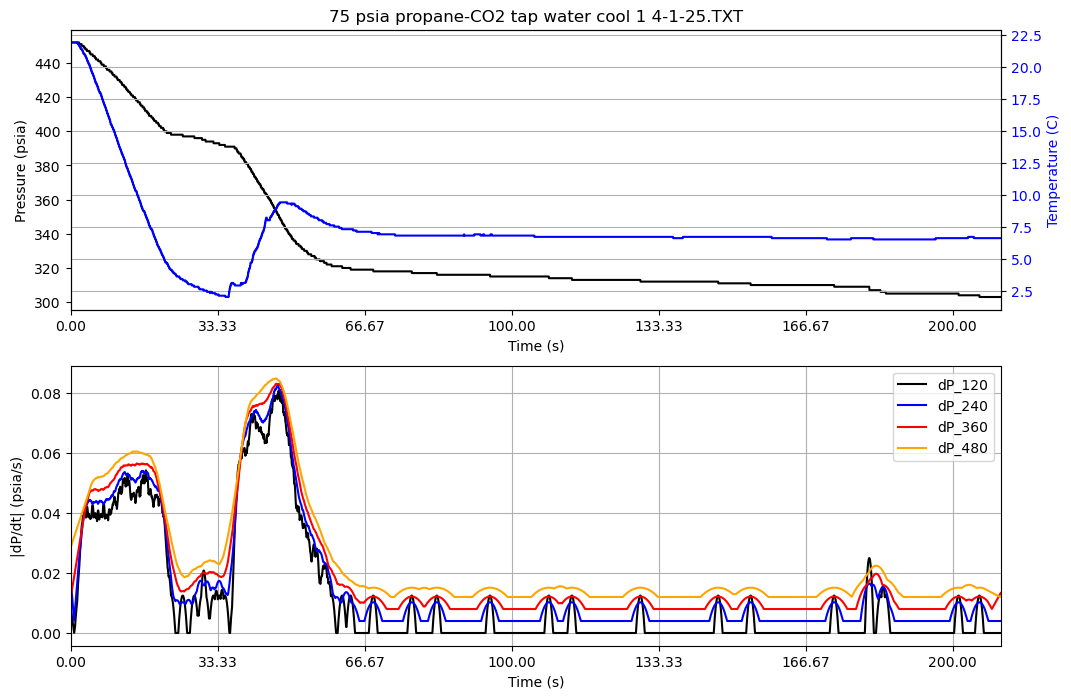

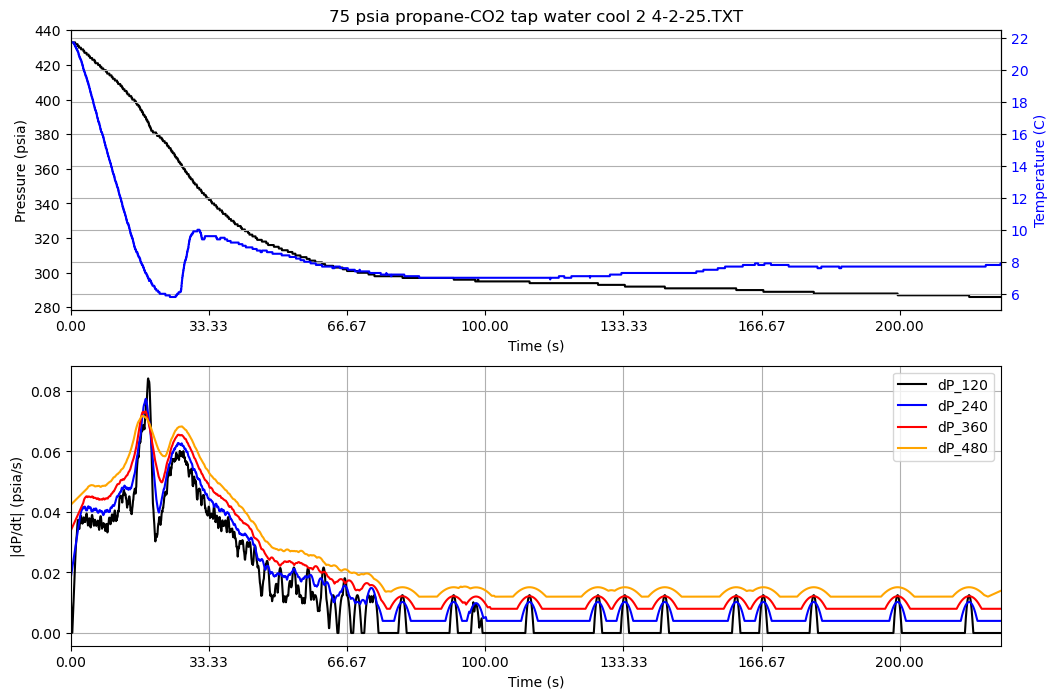

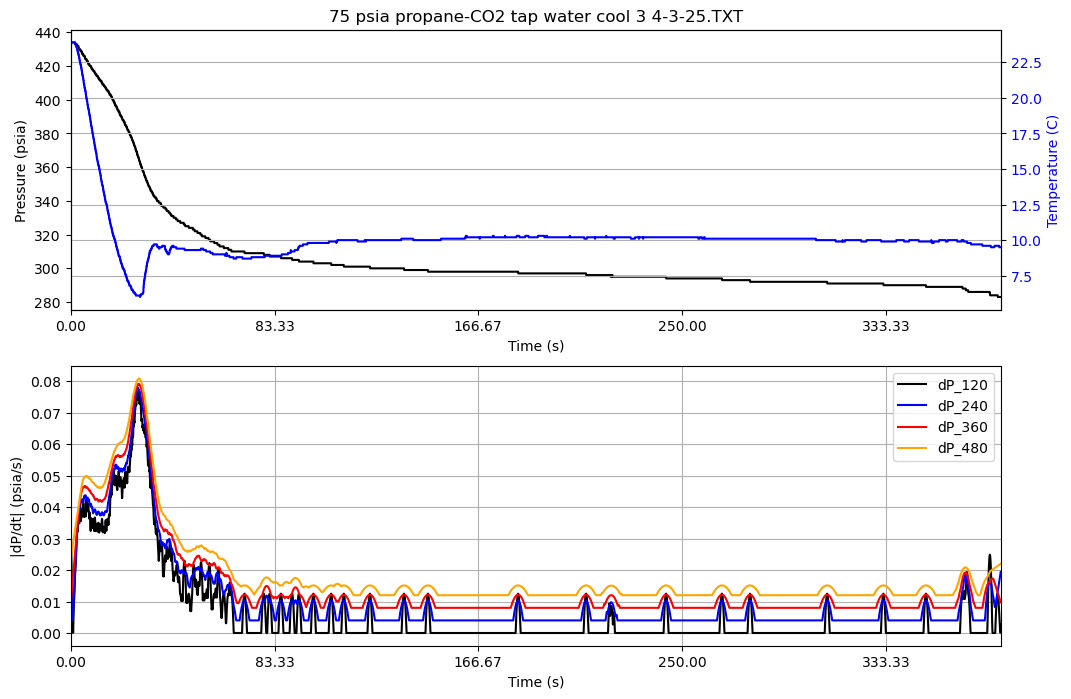

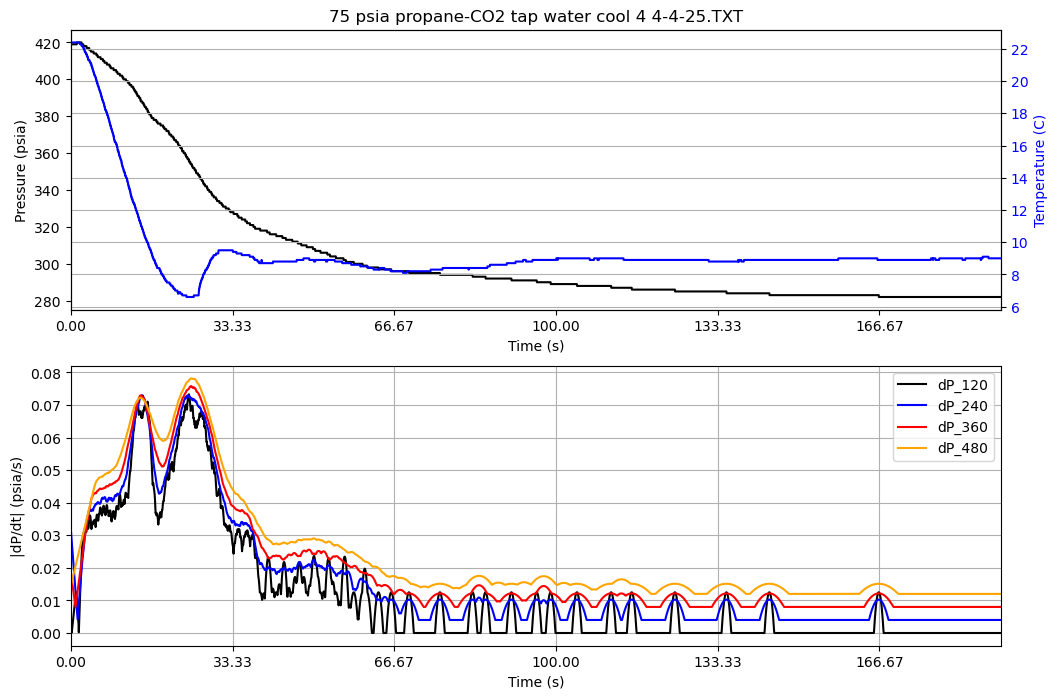

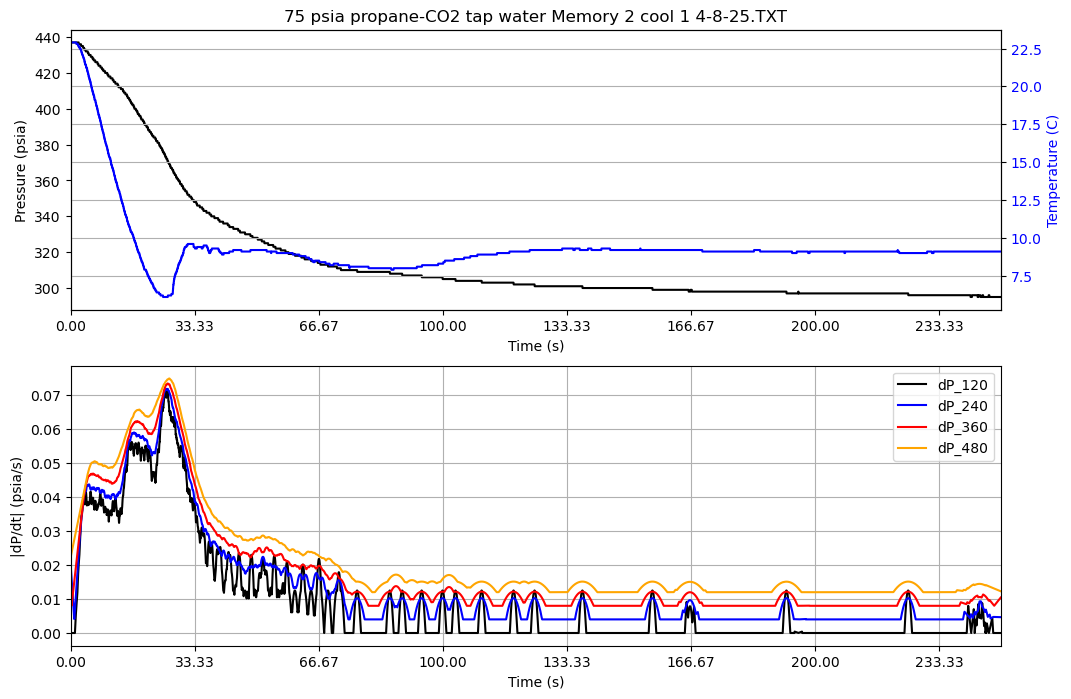

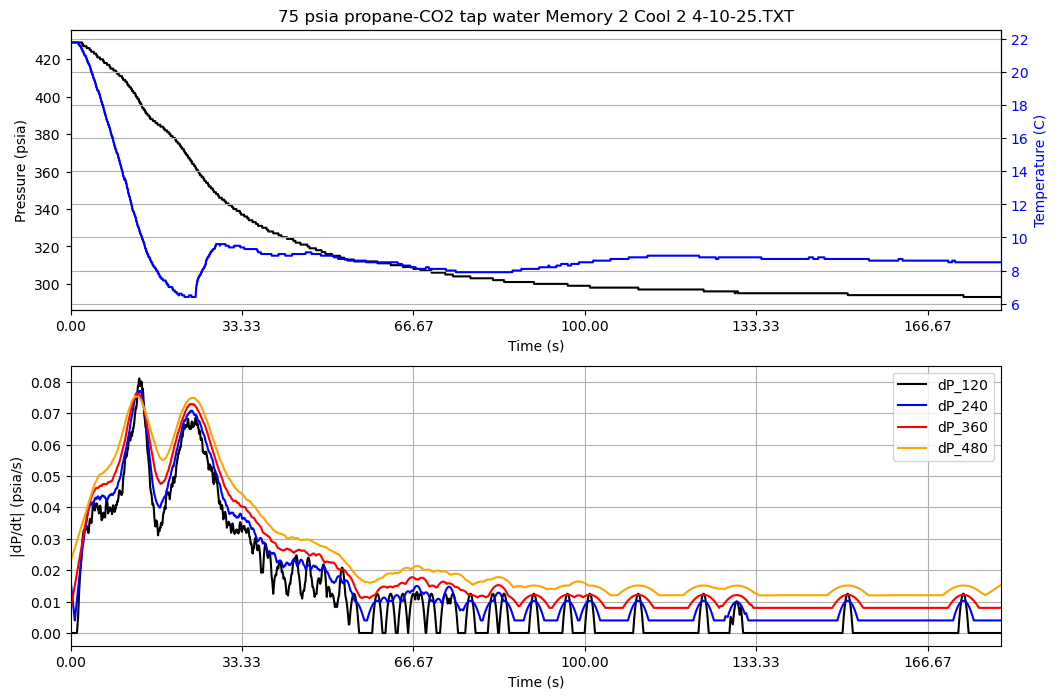

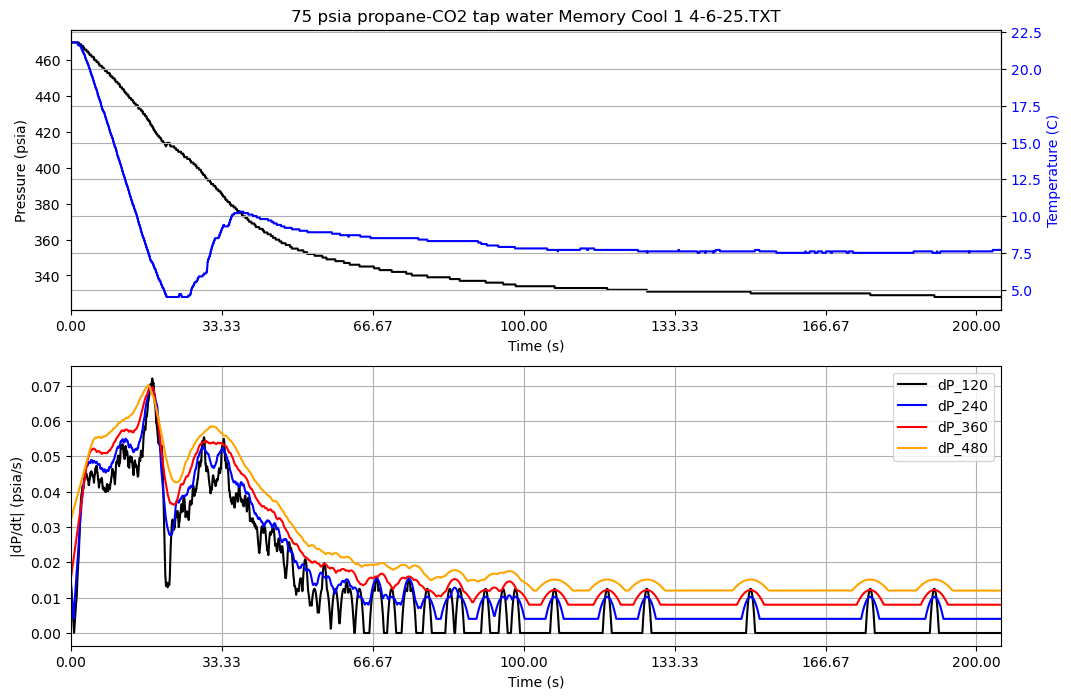

In [22]:
# Cooling: P,T v t plots & dP v t plots
data_view(clean_cool_data, 0,':')


C:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


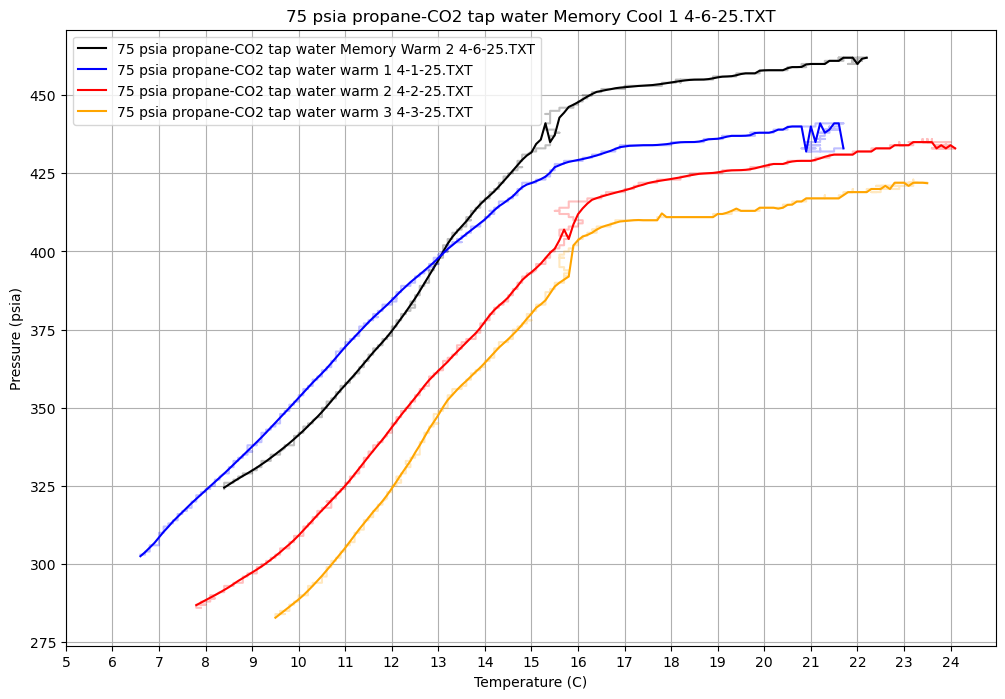

In [23]:
# Warming: P v T plots
fig = plt.figure(figsize=(12,8))
axs1 = fig.add_subplot(1,1,1)

PvT_plotter(clean_warm_data, axs1)

plt.title(f'{a}')
plt.show()

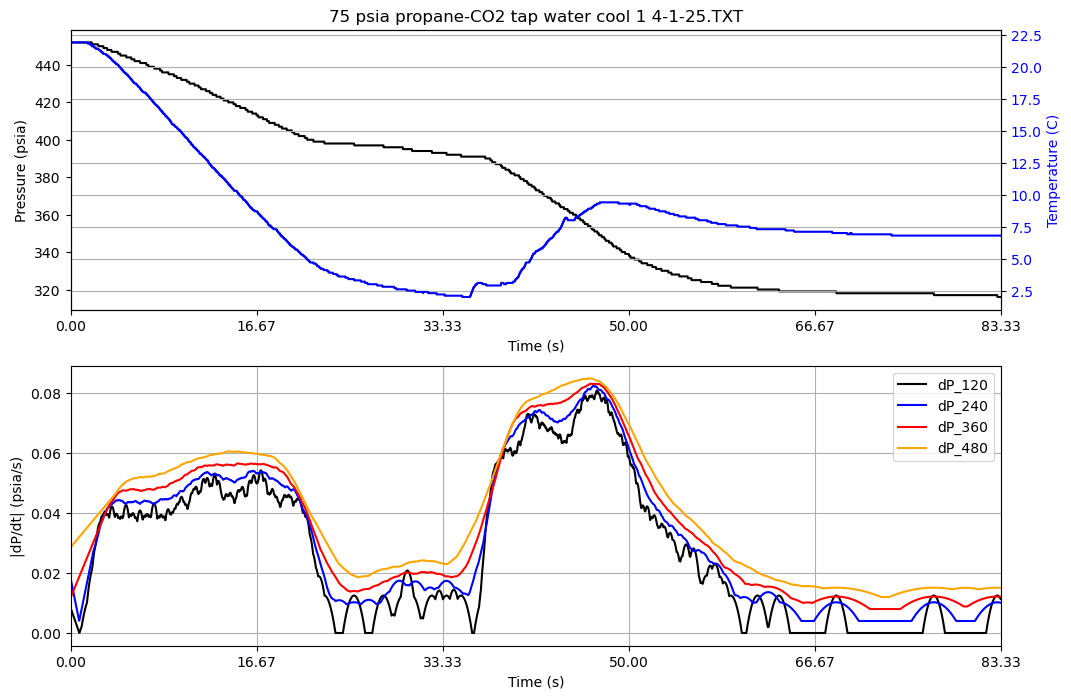

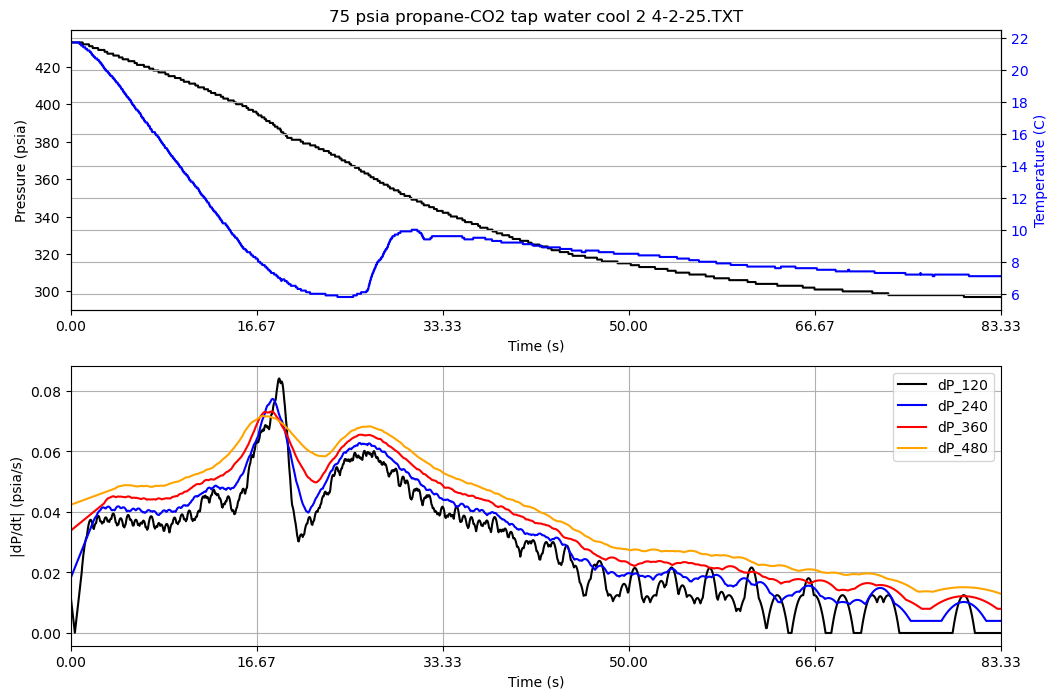

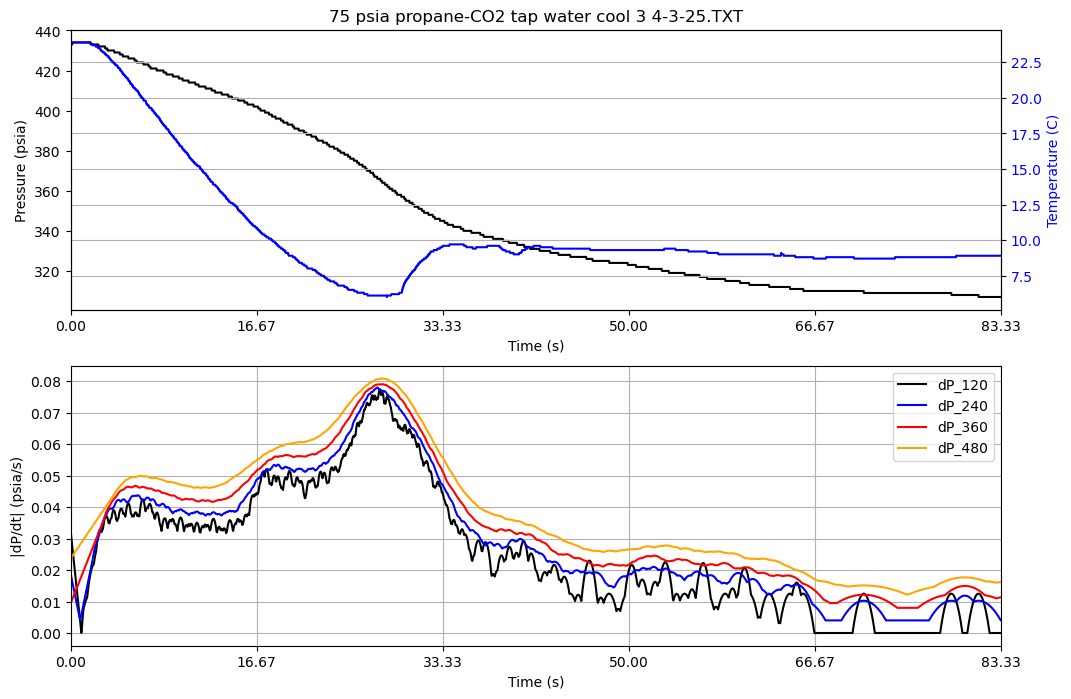

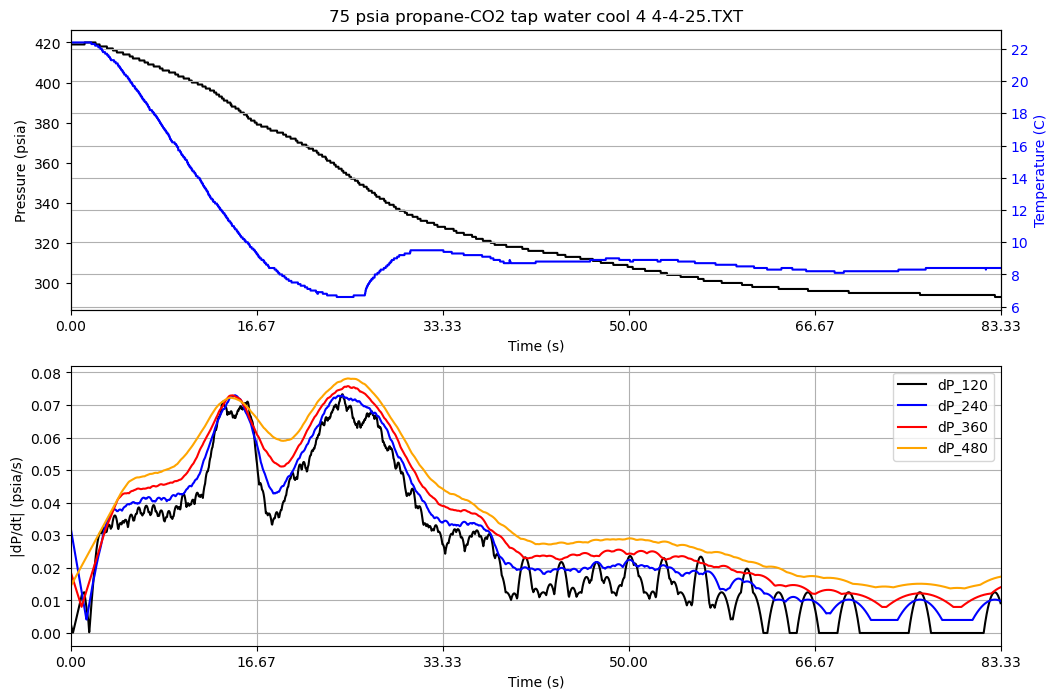

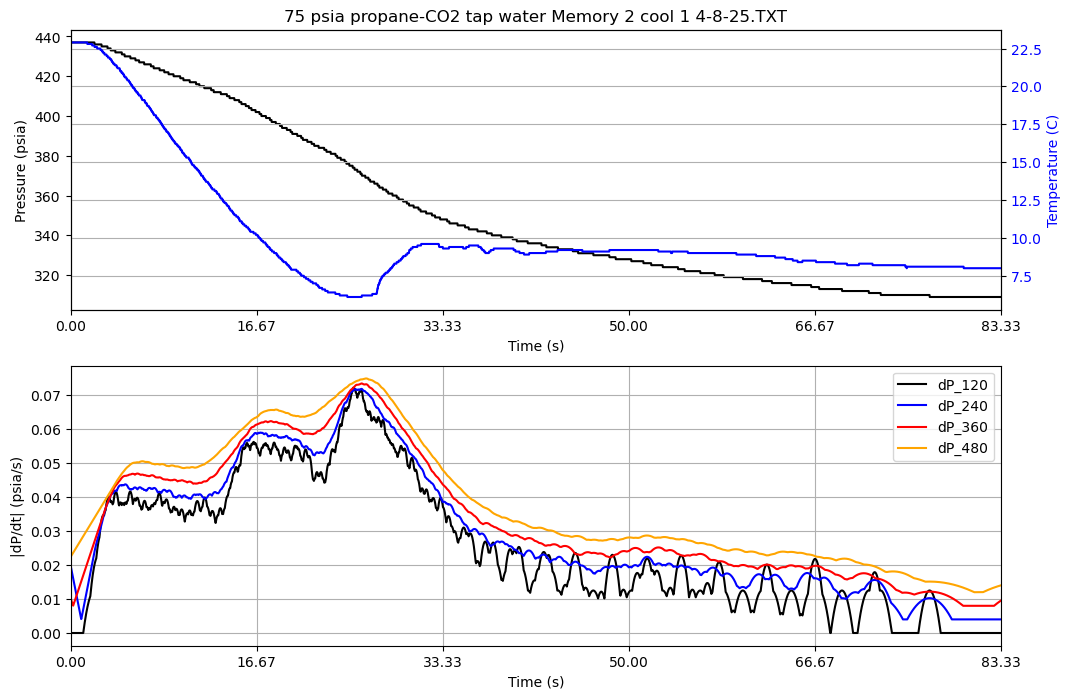

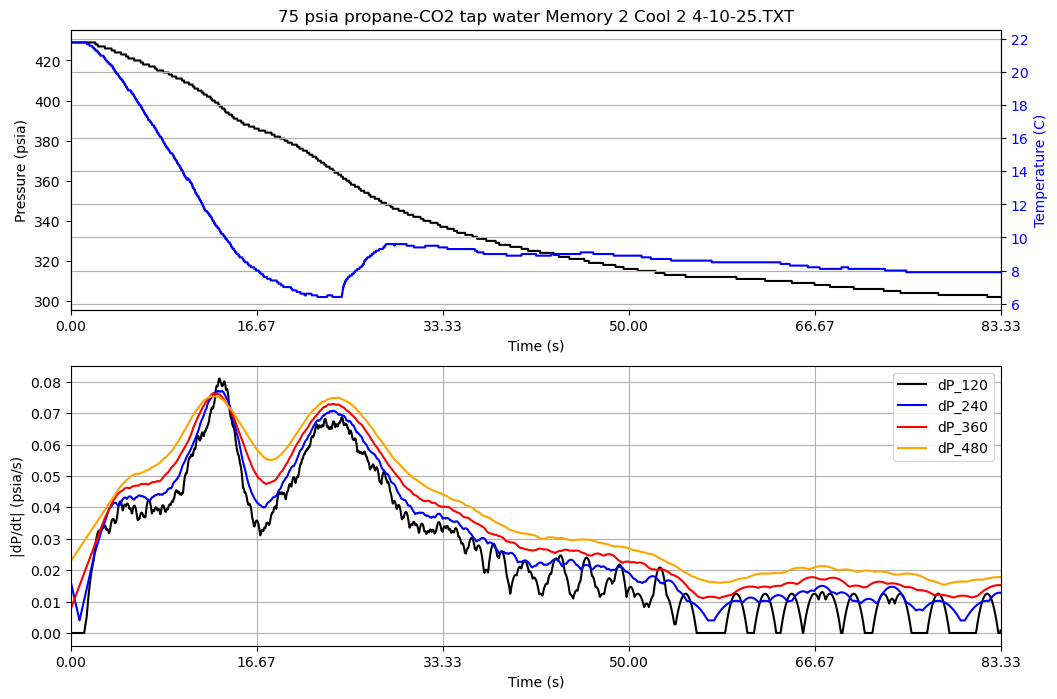

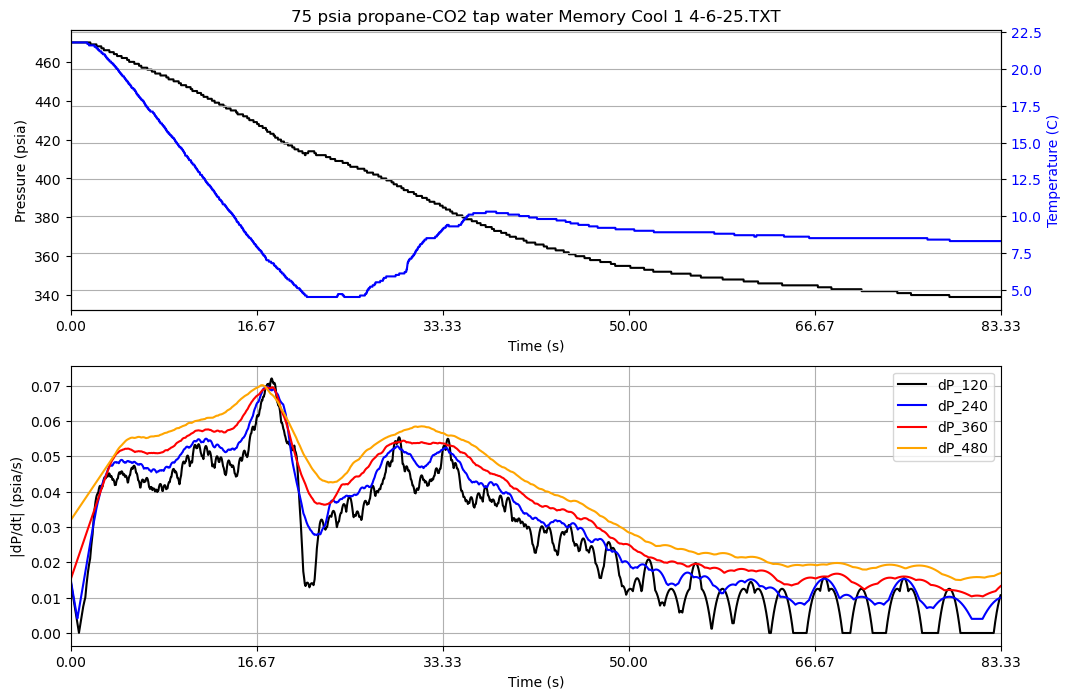

In [24]:
data_view(clean_cool_data, 0,5000)
